# Regressão Softmax com dados do MNIST

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muito atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil
Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [24]:
! pip install Pillow

In [25]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable

import torchvision

## Carregamento dos dados do MNIST

In [26]:
! git clone https://github.com/vcasadei/MNIST.git

fatal: destination path 'MNIST' already exists and is not an empty directory.


In [27]:
!ls MNIST

processed  raw


In [28]:
dataset_dir = 'MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [47]:
x_train = x_train.float()

x_train = x_train / 255.  #Normalizando

if True:
    n_samples_train = 1000

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 1000

Dimensões dos dados das imagens:    torch.Size([1000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(0.0039)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Visualizando os dados

(np.float64(-0.5), np.float64(232.5), np.float64(87.5), np.float64(-0.5))

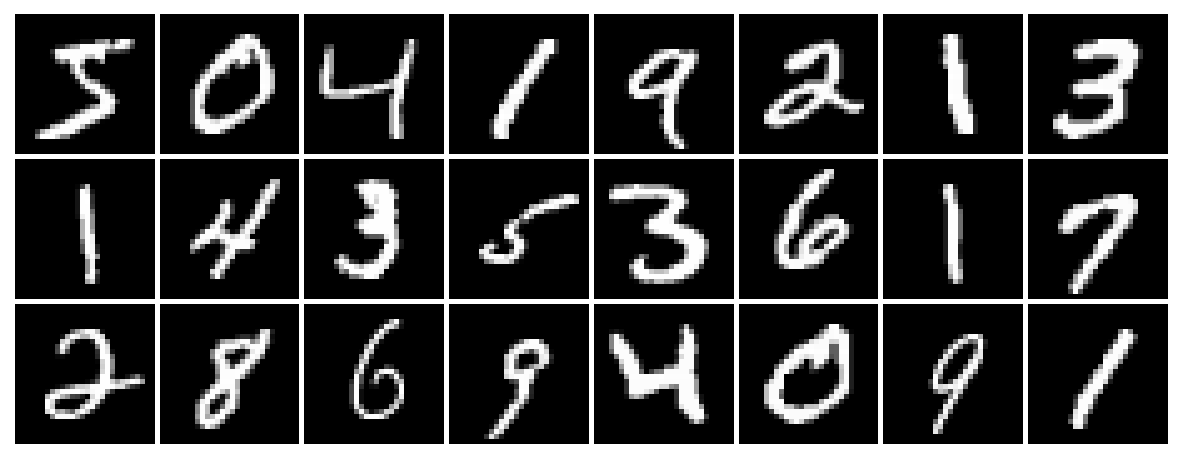

In [30]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(dim=1), pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Visualizando uma imagem com o matplotlib

class: tensor(5)


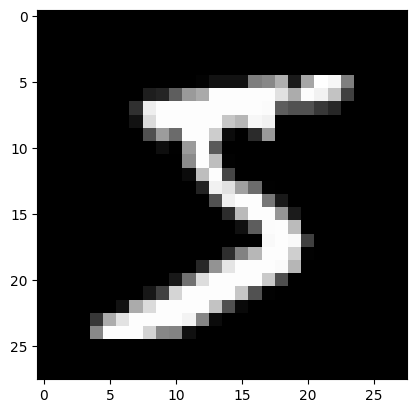

In [31]:
image  = x_train[0]
target = y_train[0]

plt.imshow(image.numpy(), cmap='gray')
print('class:', target)

## Modelo

In [32]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

### Testando um predict com poucas amostras

In [33]:
xin = x_train[:5].view(-1,28*28)
score = model(Variable(xin))
score

tensor([[-0.1149, -0.2565,  0.1898, -0.1641, -0.2448, -0.4361,  0.2931,  0.0481,
         -0.0773, -0.1107],
        [ 0.0080, -0.2793,  0.3164, -0.0113, -0.0110, -0.3536,  0.1005,  0.3202,
          0.1001, -0.1145],
        [-0.0580,  0.0829, -0.2949,  0.0819, -0.0948,  0.0620,  0.0879, -0.0675,
         -0.2479,  0.0215],
        [-0.2425, -0.2870,  0.1184, -0.1876,  0.0339, -0.3354,  0.2085, -0.0006,
         -0.1214, -0.0500],
        [ 0.1916, -0.3469,  0.3242, -0.2795, -0.1046, -0.1544,  0.1583, -0.1099,
          0.3223, -0.1995]], grad_fn=<AddmmBackward0>)

## Treinamento

### Inicialização dos parâmetros

In [34]:
epochs = 100
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Visualização do grafo computacional da perda (loss)

In [35]:
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz

  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-bxy_vl4f
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz /tmp/pip-req-build-bxy_vl4f
  Resolved https://github.com/szagoruyko/pytorchviz to commit 5cf04c13e601366f6b9cf5939b5af5144d55b887
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [36]:
from torchviz import make_dot, make_dot_from_trace
y_pred = model(Variable(x_train.view(-1,28*28)))
loss = criterion(y_pred, Variable(y_train))
loss


tensor(2.3240, grad_fn=<NllLossBackward0>)

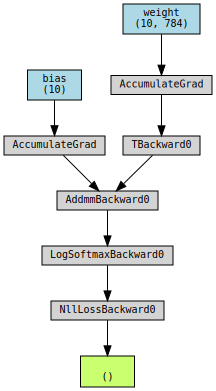

In [37]:
p = make_dot(loss, dict(model.named_parameters()))
p

### Laço de treinamento dos pesos

In [38]:
import numpy
losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()


In [39]:
print('Final loss:', loss.item())

Final loss: 0.26476985216140747


### Visualizando gráfico de perda durante o treinamento

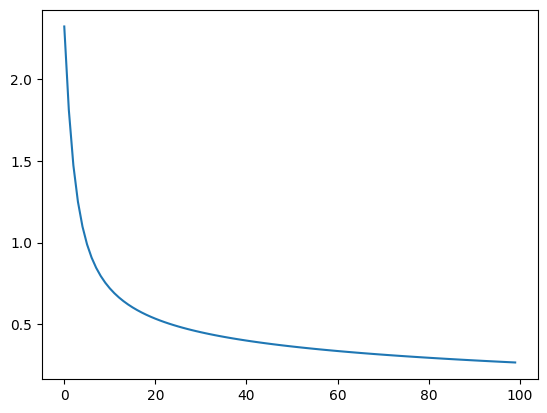

In [40]:
plt.plot(losses)

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [41]:
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)

    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.941


### Matriz de confusão com dados de treinamento e teste

In [42]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,96,0,1,0,0,0,1,0,0,2
1,0,110,2,0,0,0,2,3,1,0
2,0,1,90,1,0,1,1,1,1,1
3,0,0,0,88,0,2,0,0,0,0
4,0,0,1,0,102,2,0,2,0,3
5,0,2,0,1,0,82,0,0,2,1
6,1,0,1,1,2,2,90,0,0,0
7,0,1,1,1,0,0,0,110,0,3
8,0,2,2,0,0,1,0,0,83,0


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


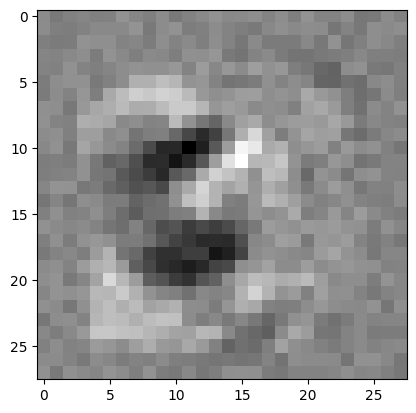

In [43]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

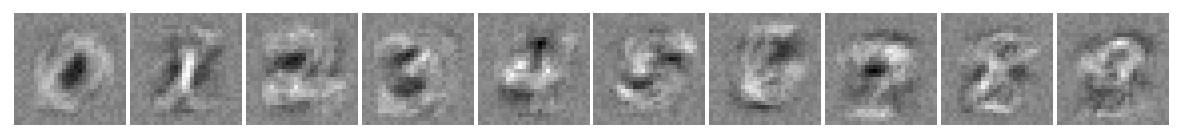

In [44]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off');

### Diagrama da regressão softmax com visualização dos pesos W

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmaxArgmaxNMIST.png)

# Atividades

## Exercícios

- 1) Insira código no laço do treinamento para que no final de cada época,
     seja impresso: o número da época e a perda e a acurácia

In [45]:
# Exercicio 1
import numpy
losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()

    # Imprime perda e acurácia da época atual
    print(f"Época {i+1}/{epochs} - Perda: {loss.item():.4f} - Acurácia: {accuracy:.4f}")


Época 1/100 - Perda: 0.2634 - Acurácia: 0.9410
Época 2/100 - Perda: 0.2621 - Acurácia: 0.9410
Época 3/100 - Perda: 0.2608 - Acurácia: 0.9410
Época 4/100 - Perda: 0.2595 - Acurácia: 0.9410
Época 5/100 - Perda: 0.2583 - Acurácia: 0.9420
Época 6/100 - Perda: 0.2570 - Acurácia: 0.9430
Época 7/100 - Perda: 0.2558 - Acurácia: 0.9430
Época 8/100 - Perda: 0.2545 - Acurácia: 0.9430
Época 9/100 - Perda: 0.2533 - Acurácia: 0.9430
Época 10/100 - Perda: 0.2521 - Acurácia: 0.9440
Época 11/100 - Perda: 0.2509 - Acurácia: 0.9440
Época 12/100 - Perda: 0.2498 - Acurácia: 0.9440
Época 13/100 - Perda: 0.2486 - Acurácia: 0.9450
Época 14/100 - Perda: 0.2475 - Acurácia: 0.9460
Época 15/100 - Perda: 0.2463 - Acurácia: 0.9480
Época 16/100 - Perda: 0.2452 - Acurácia: 0.9480
Época 17/100 - Perda: 0.2441 - Acurácia: 0.9500
Época 18/100 - Perda: 0.2430 - Acurácia: 0.9500
Época 19/100 - Perda: 0.2419 - Acurácia: 0.9500
Época 20/100 - Perda: 0.2408 - Acurácia: 0.9500
Época 21/100 - Perda: 0.2397 - Acurácia: 0.9500
É

- 2) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.

<details>
<summary>Mostrar Resultado</summary>

```python
losses = []
import numpy

import numpy
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)
    
    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    
    _, predicts = torch.max(outputs, 1)
    
    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()
    
    print('Epoch[{}/{}], loss: {:.6f}, acc: {:.6f}'
              .format(i+1, epochs, loss.data, accuracy))
    
    weights = model.state_dict()['weight']
    print('weights:', weights.shape)

    bias = model.state_dict()['bias']
    print('bias:   ', bias.shape)

    # Visualizando pesos da classe 3
    plt.imshow(weights[4, :].numpy().reshape((28,28)),cmap = 'gray')
    plt.show()
```

</details>

Epoch[1/100], loss: 0.177753, acc: 0.967000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


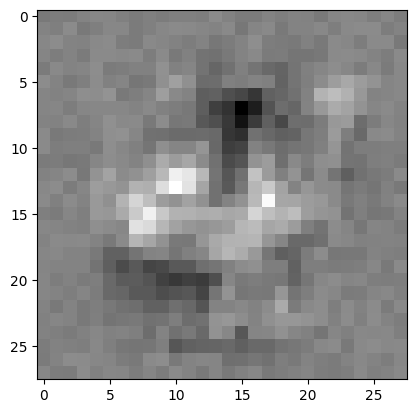

Epoch[2/100], loss: 0.177182, acc: 0.967000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


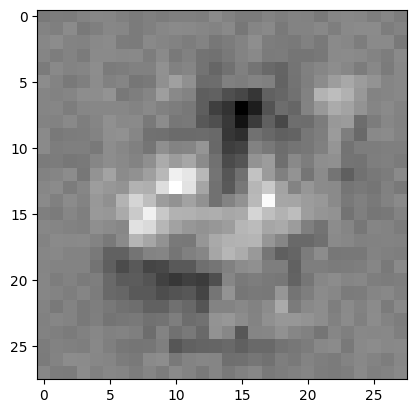

Epoch[3/100], loss: 0.176614, acc: 0.967000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


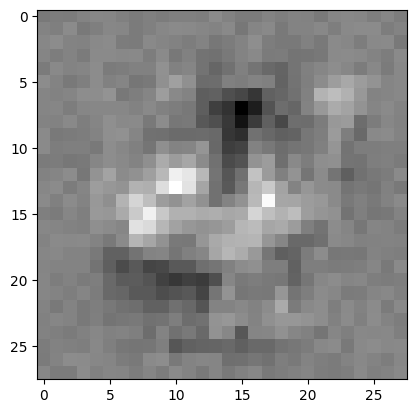

Epoch[4/100], loss: 0.176050, acc: 0.967000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


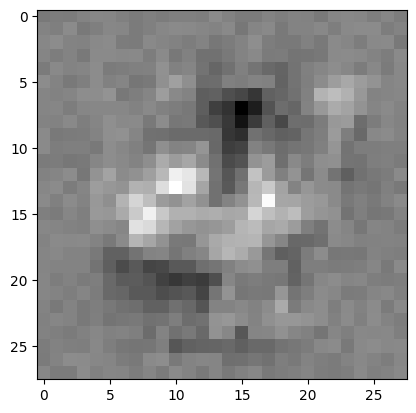

Epoch[5/100], loss: 0.175489, acc: 0.968000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


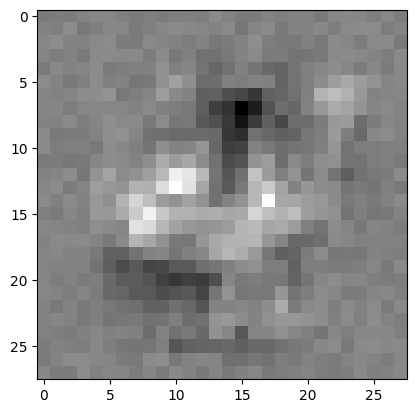

Epoch[6/100], loss: 0.174932, acc: 0.968000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


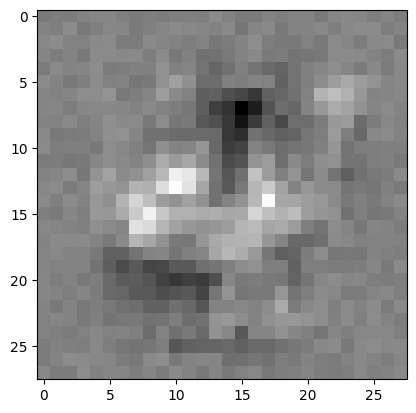

Epoch[7/100], loss: 0.174378, acc: 0.968000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


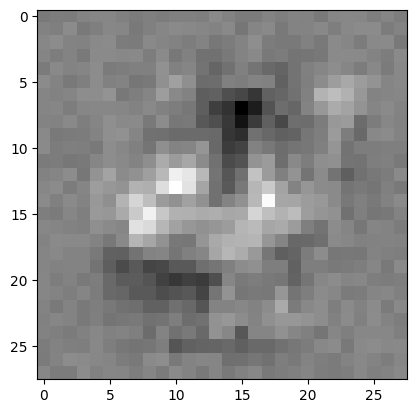

Epoch[8/100], loss: 0.173827, acc: 0.968000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


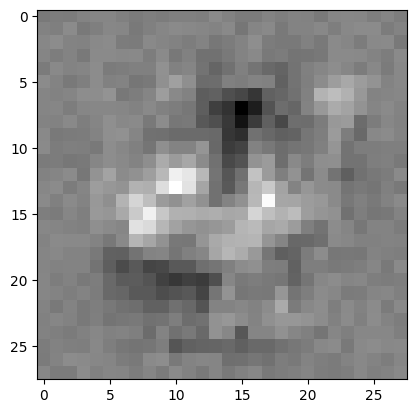

Epoch[9/100], loss: 0.173280, acc: 0.968000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


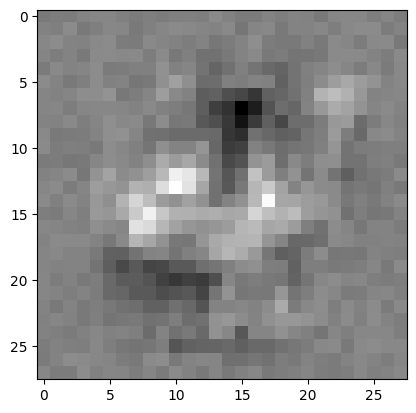

Epoch[10/100], loss: 0.172736, acc: 0.968000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


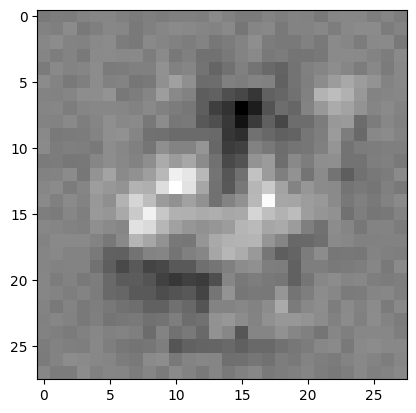

Epoch[11/100], loss: 0.172195, acc: 0.968000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


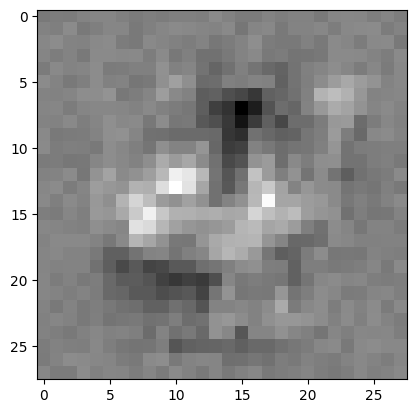

Epoch[12/100], loss: 0.171657, acc: 0.968000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


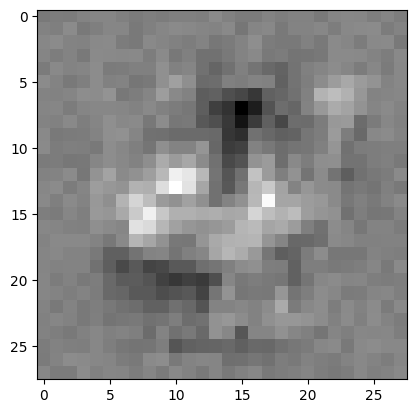

Epoch[13/100], loss: 0.171123, acc: 0.968000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


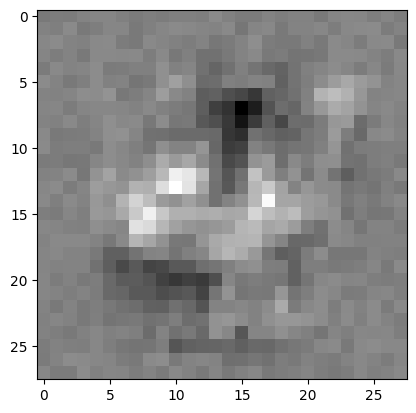

Epoch[14/100], loss: 0.170592, acc: 0.968000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


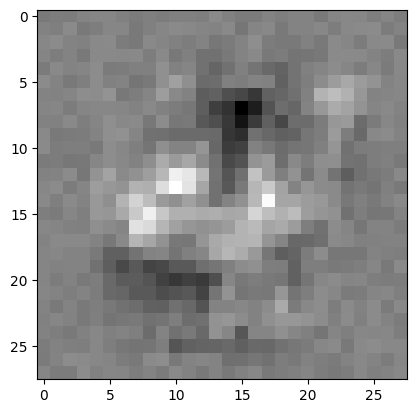

Epoch[15/100], loss: 0.170064, acc: 0.968000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


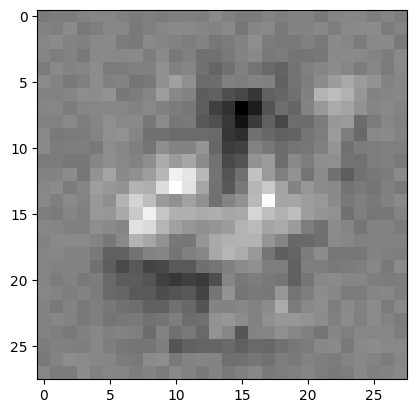

Epoch[16/100], loss: 0.169539, acc: 0.968000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


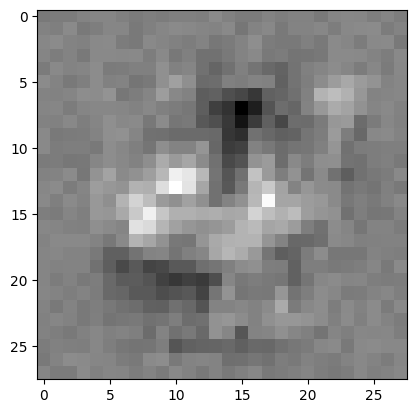

Epoch[17/100], loss: 0.169017, acc: 0.969000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


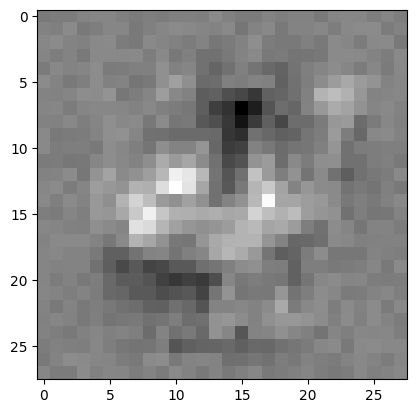

Epoch[18/100], loss: 0.168498, acc: 0.969000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


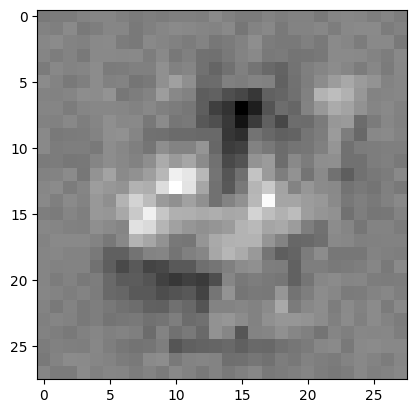

Epoch[19/100], loss: 0.167982, acc: 0.969000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


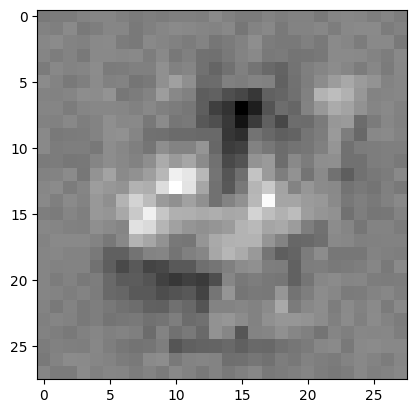

Epoch[20/100], loss: 0.167469, acc: 0.969000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


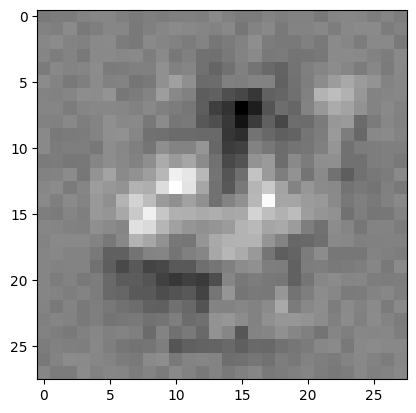

Epoch[21/100], loss: 0.166959, acc: 0.969000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


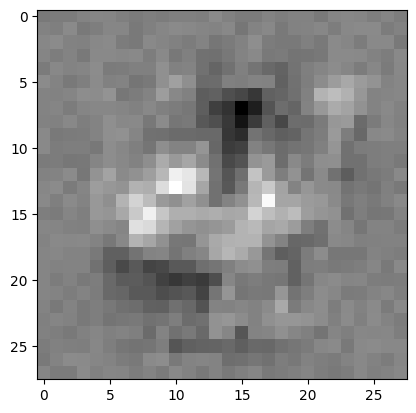

Epoch[22/100], loss: 0.166452, acc: 0.969000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


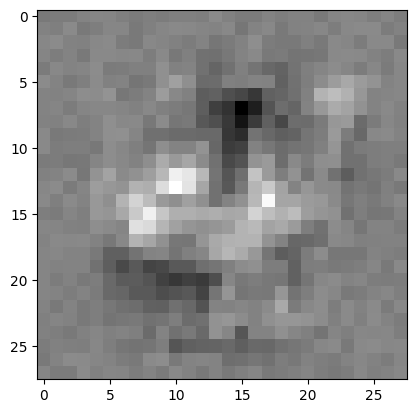

Epoch[23/100], loss: 0.165948, acc: 0.969000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


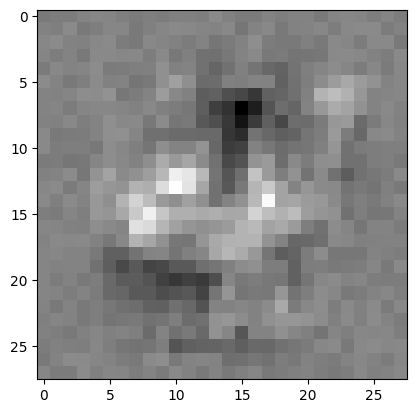

Epoch[24/100], loss: 0.165447, acc: 0.969000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


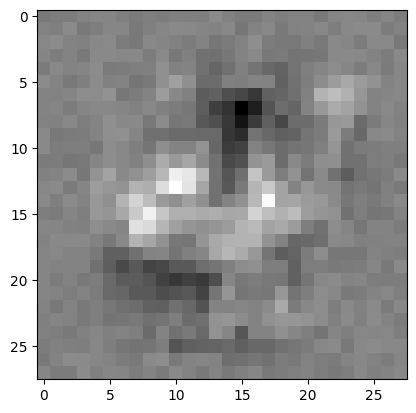

Epoch[25/100], loss: 0.164949, acc: 0.969000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


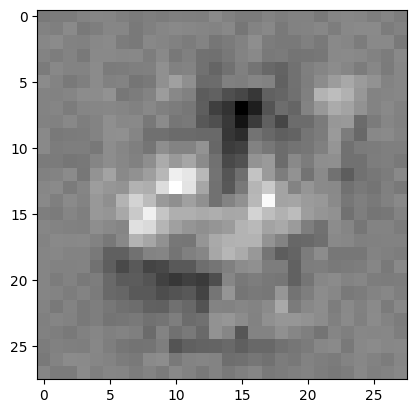

Epoch[26/100], loss: 0.164453, acc: 0.969000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


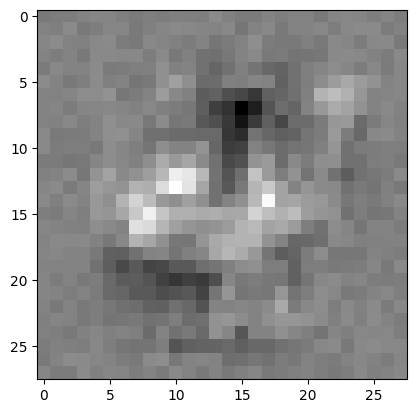

Epoch[27/100], loss: 0.163960, acc: 0.970000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


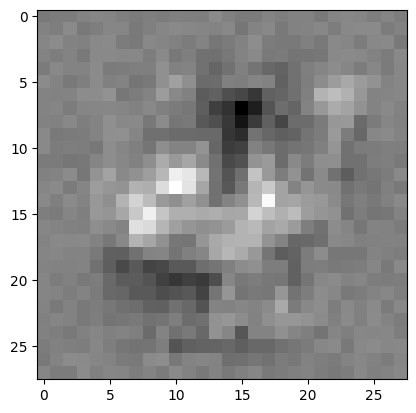

Epoch[28/100], loss: 0.163470, acc: 0.970000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


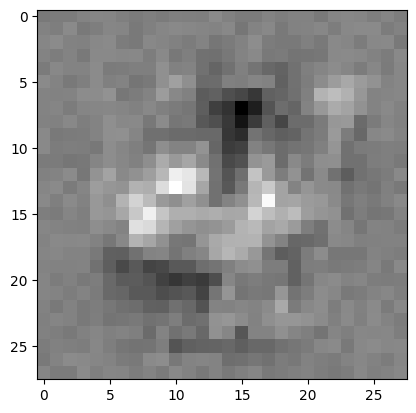

Epoch[29/100], loss: 0.162983, acc: 0.970000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


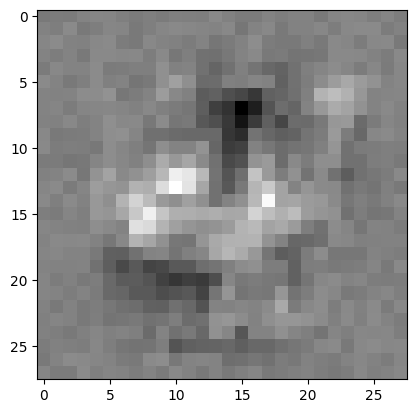

Epoch[30/100], loss: 0.162498, acc: 0.971000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


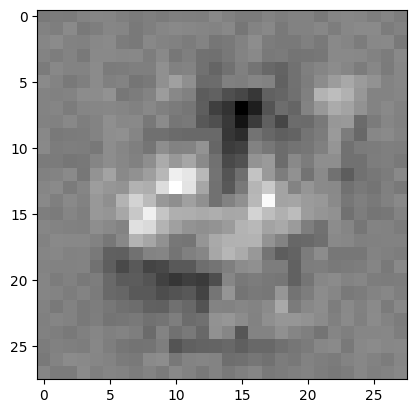

Epoch[31/100], loss: 0.162017, acc: 0.971000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


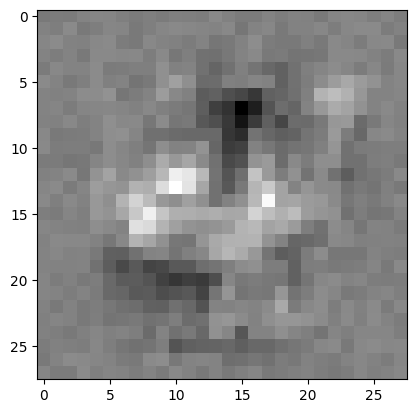

Epoch[32/100], loss: 0.161537, acc: 0.972000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


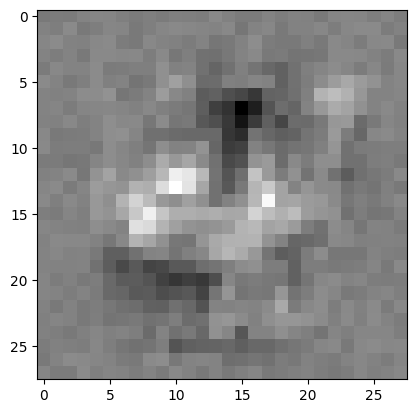

Epoch[33/100], loss: 0.161061, acc: 0.972000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


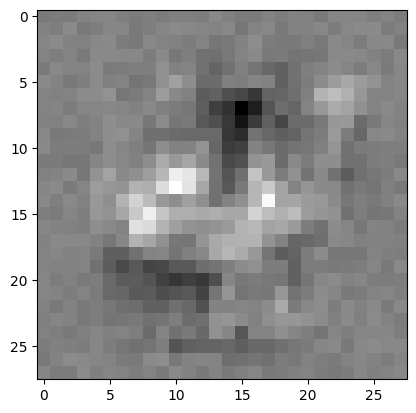

Epoch[34/100], loss: 0.160587, acc: 0.972000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


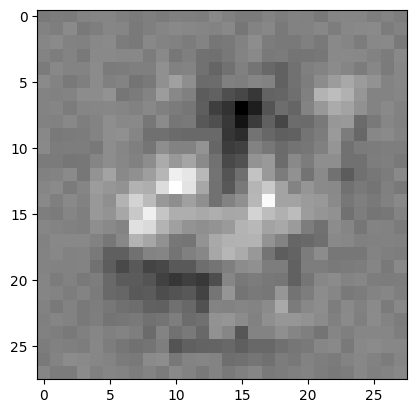

Epoch[35/100], loss: 0.160115, acc: 0.972000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


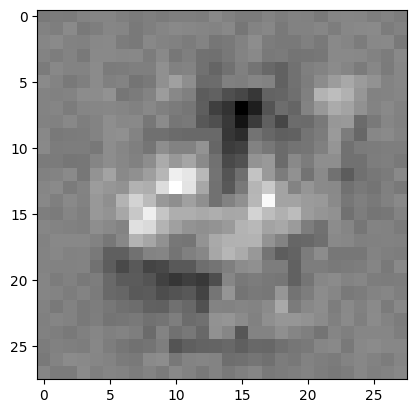

Epoch[36/100], loss: 0.159647, acc: 0.972000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


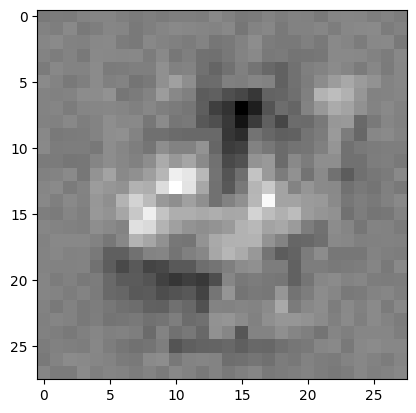

Epoch[37/100], loss: 0.159180, acc: 0.973000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


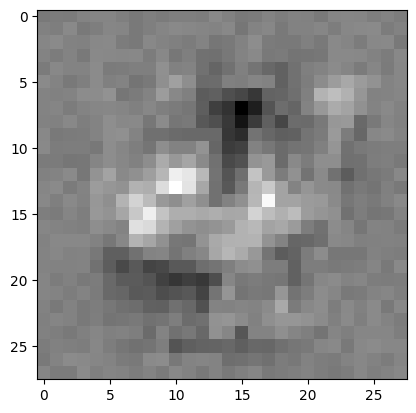

Epoch[38/100], loss: 0.158717, acc: 0.973000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


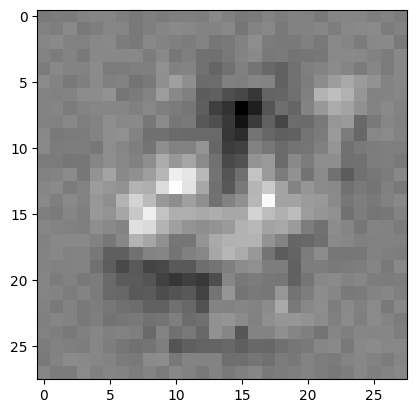

Epoch[39/100], loss: 0.158256, acc: 0.974000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


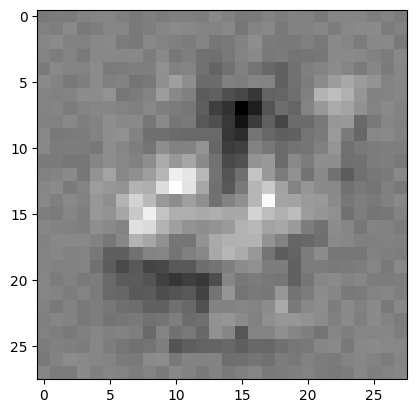

Epoch[40/100], loss: 0.157797, acc: 0.974000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


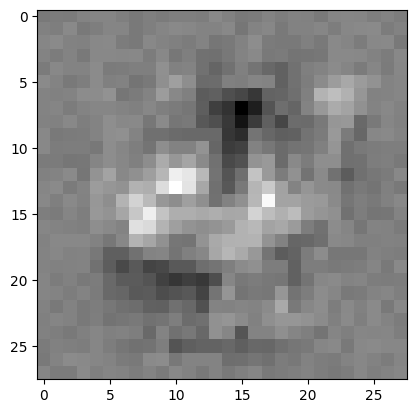

Epoch[41/100], loss: 0.157340, acc: 0.974000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


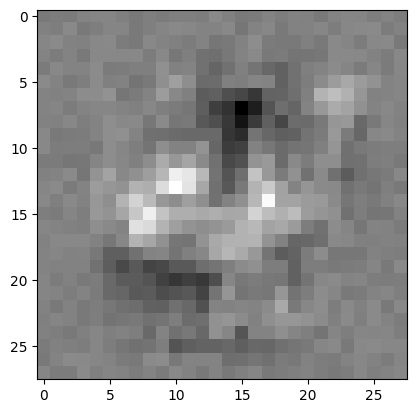

Epoch[42/100], loss: 0.156887, acc: 0.974000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


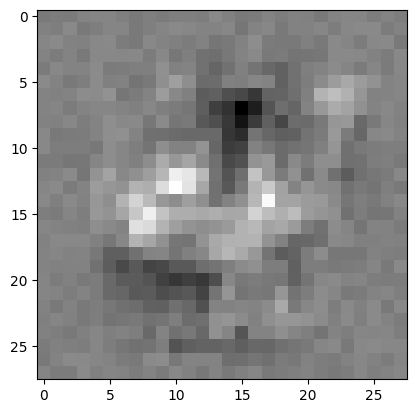

Epoch[43/100], loss: 0.156435, acc: 0.974000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


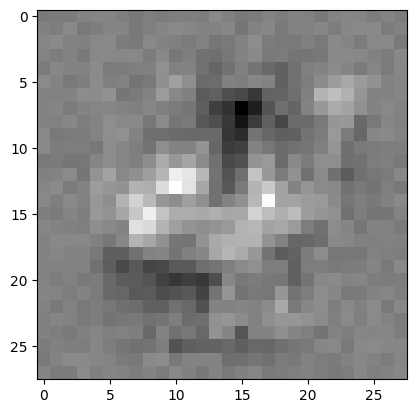

Epoch[44/100], loss: 0.155986, acc: 0.974000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


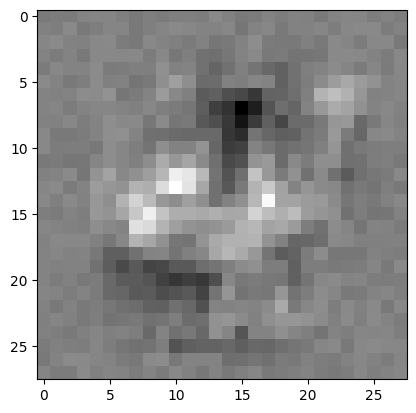

Epoch[45/100], loss: 0.155540, acc: 0.974000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


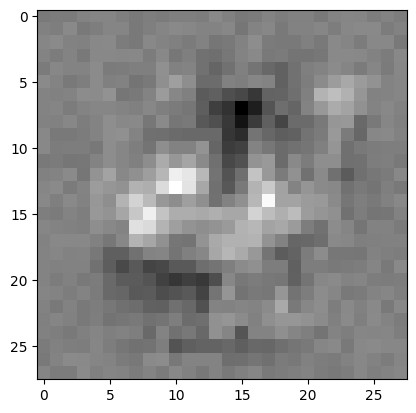

Epoch[46/100], loss: 0.155095, acc: 0.974000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


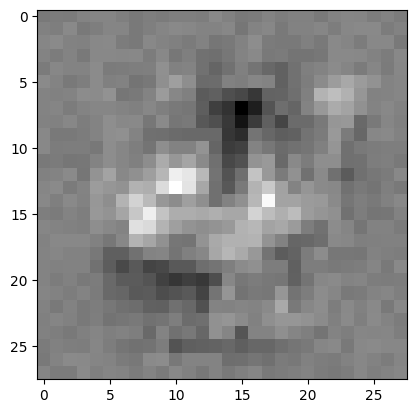

Epoch[47/100], loss: 0.154653, acc: 0.974000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


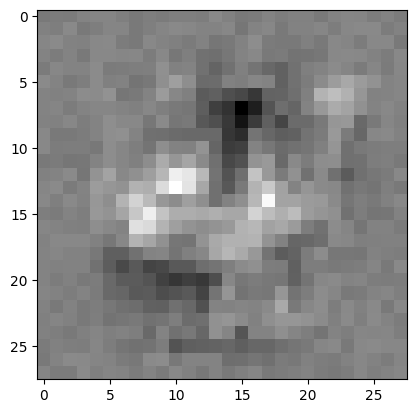

Epoch[48/100], loss: 0.154214, acc: 0.974000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


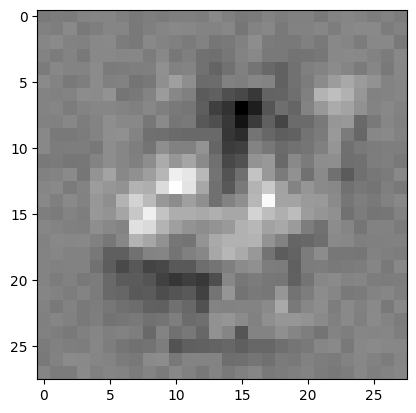

Epoch[49/100], loss: 0.153777, acc: 0.974000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


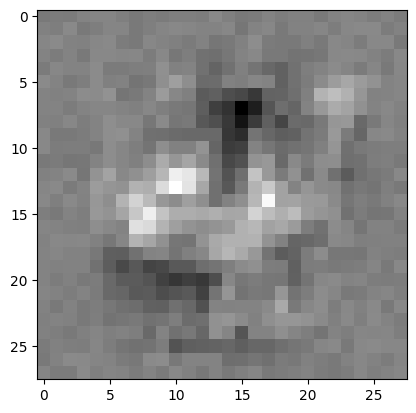

Epoch[50/100], loss: 0.153341, acc: 0.974000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


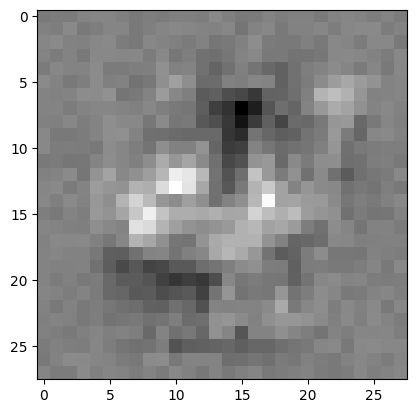

Epoch[51/100], loss: 0.152909, acc: 0.975000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


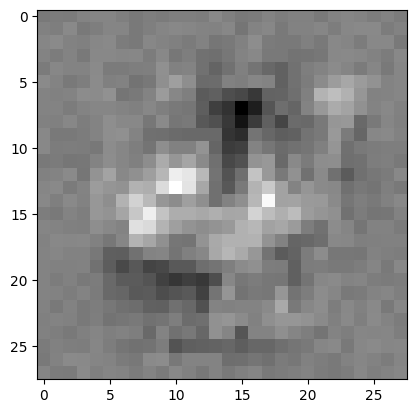

Epoch[52/100], loss: 0.152478, acc: 0.975000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


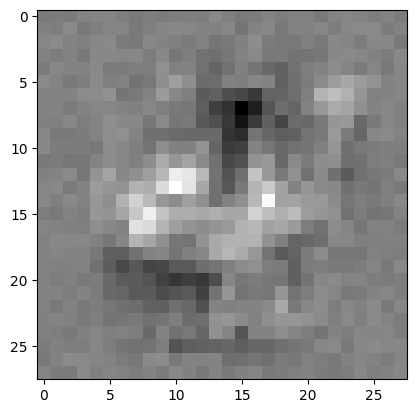

Epoch[53/100], loss: 0.152050, acc: 0.975000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


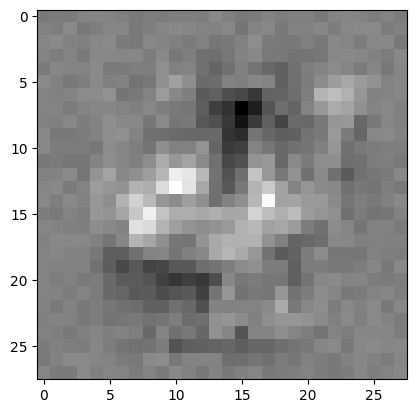

Epoch[54/100], loss: 0.151624, acc: 0.975000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


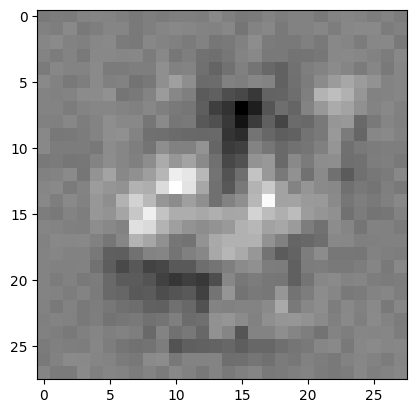

Epoch[55/100], loss: 0.151200, acc: 0.975000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


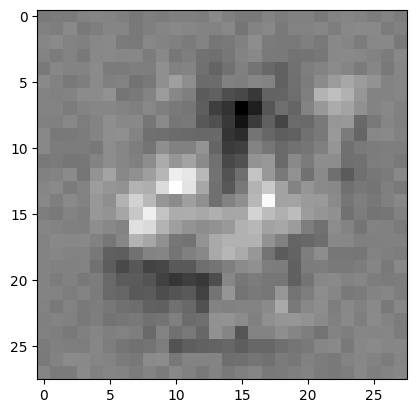

Epoch[56/100], loss: 0.150778, acc: 0.975000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


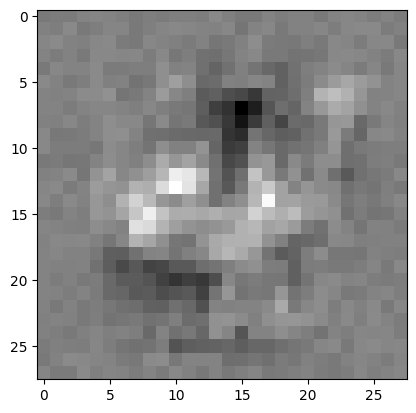

Epoch[57/100], loss: 0.150358, acc: 0.975000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


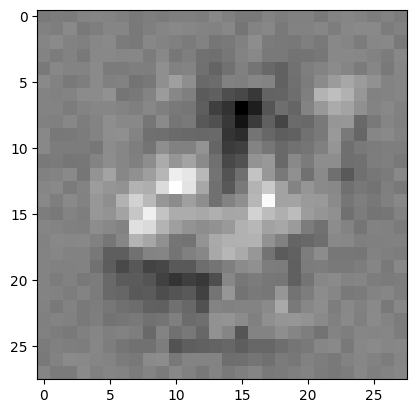

Epoch[58/100], loss: 0.149941, acc: 0.975000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


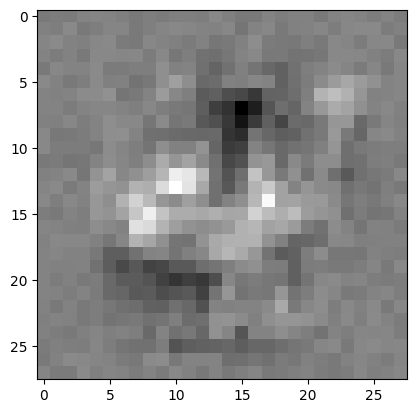

Epoch[59/100], loss: 0.149526, acc: 0.975000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


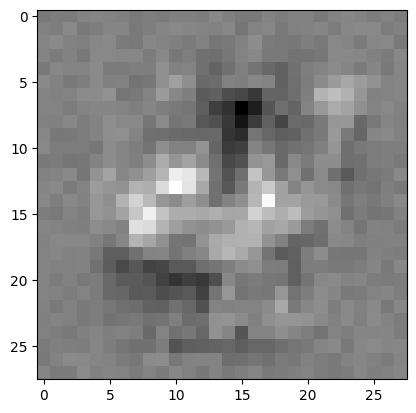

Epoch[60/100], loss: 0.149113, acc: 0.975000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


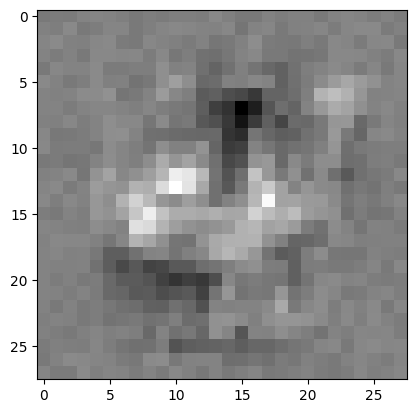

Epoch[61/100], loss: 0.148701, acc: 0.975000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


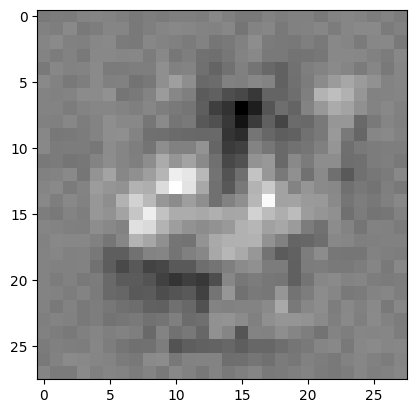

Epoch[62/100], loss: 0.148292, acc: 0.975000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


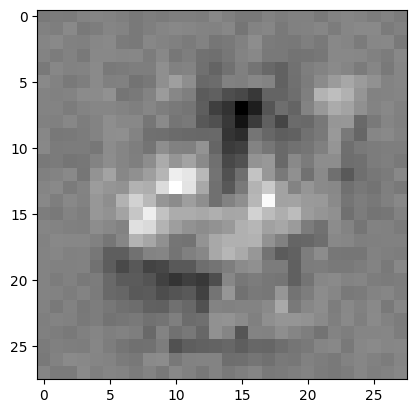

Epoch[63/100], loss: 0.147885, acc: 0.975000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


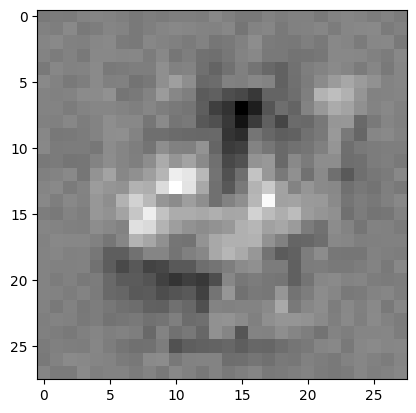

Epoch[64/100], loss: 0.147480, acc: 0.975000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


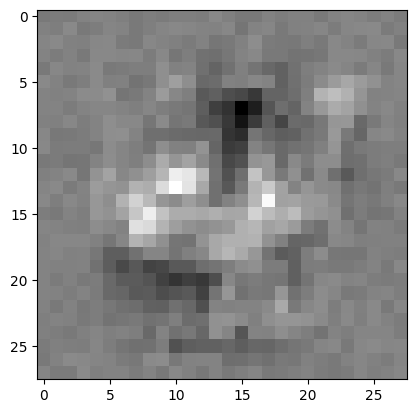

Epoch[65/100], loss: 0.147077, acc: 0.975000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


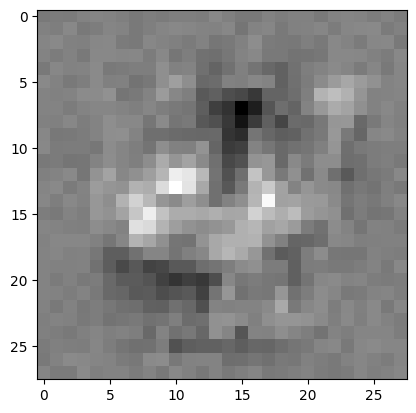

Epoch[66/100], loss: 0.146676, acc: 0.975000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


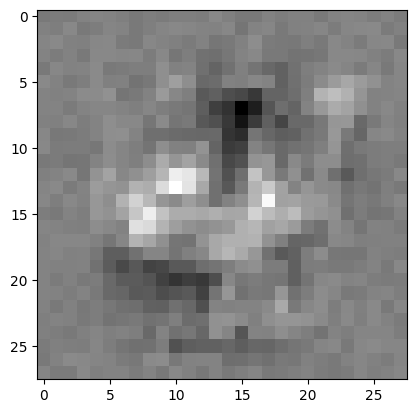

Epoch[67/100], loss: 0.146277, acc: 0.975000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


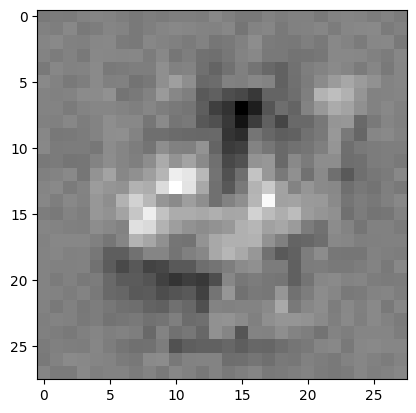

Epoch[68/100], loss: 0.145880, acc: 0.975000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


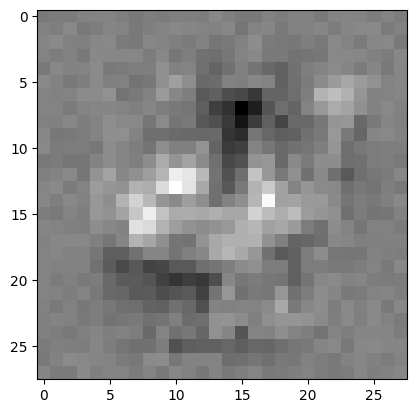

Epoch[69/100], loss: 0.145485, acc: 0.975000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


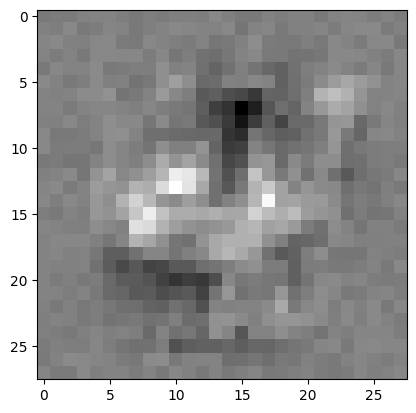

Epoch[70/100], loss: 0.145092, acc: 0.975000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


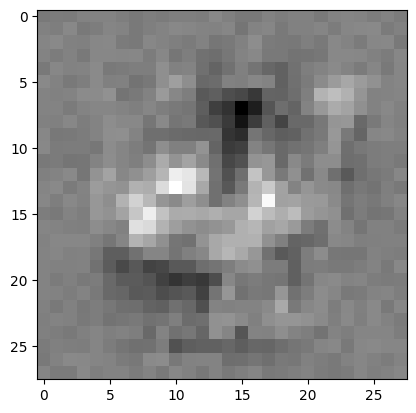

Epoch[71/100], loss: 0.144701, acc: 0.975000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


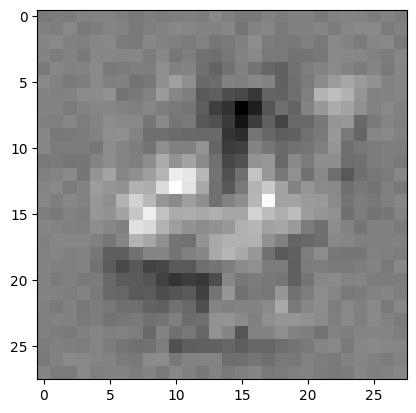

Epoch[72/100], loss: 0.144312, acc: 0.975000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


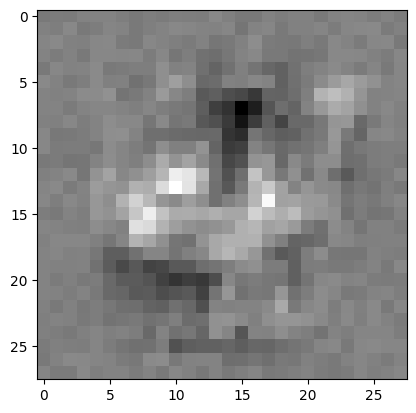

Epoch[73/100], loss: 0.143925, acc: 0.975000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


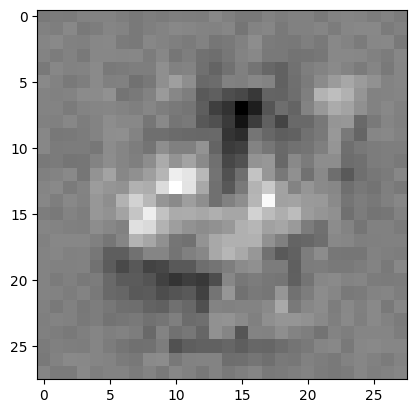

Epoch[74/100], loss: 0.143539, acc: 0.975000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


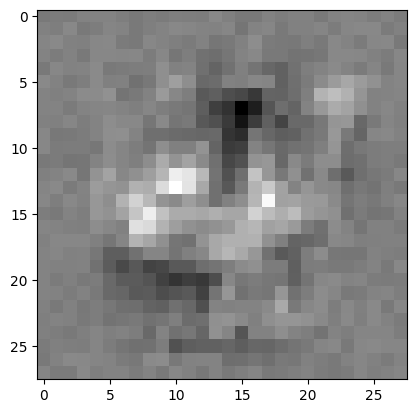

Epoch[75/100], loss: 0.143156, acc: 0.976000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


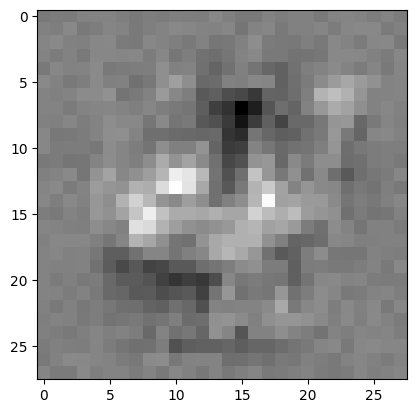

Epoch[76/100], loss: 0.142774, acc: 0.976000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


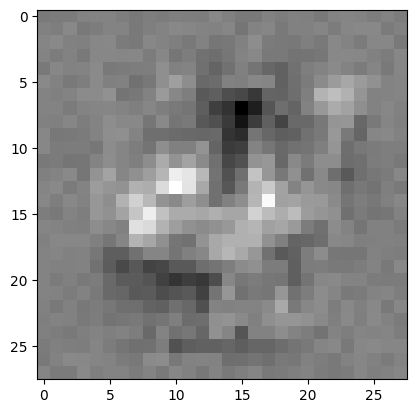

Epoch[77/100], loss: 0.142394, acc: 0.976000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


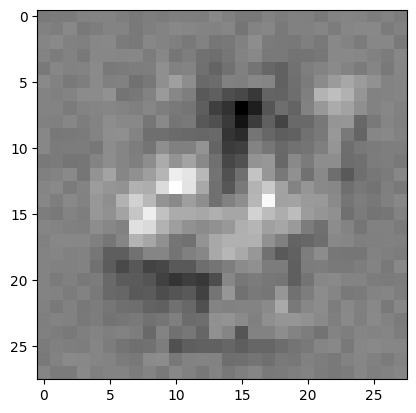

Epoch[78/100], loss: 0.142016, acc: 0.976000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


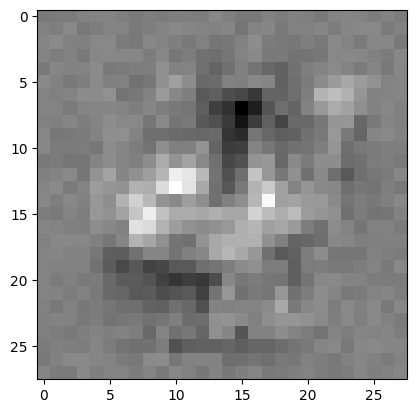

Epoch[79/100], loss: 0.141640, acc: 0.976000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


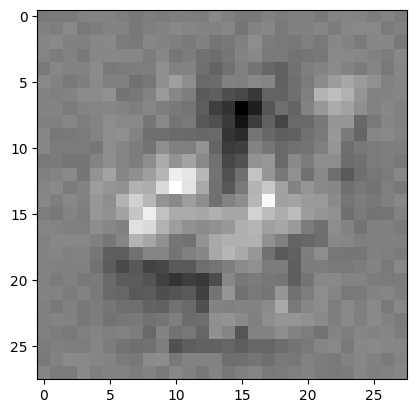

Epoch[80/100], loss: 0.141265, acc: 0.976000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


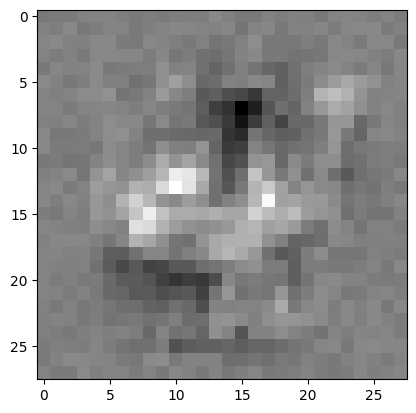

Epoch[81/100], loss: 0.140893, acc: 0.976000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


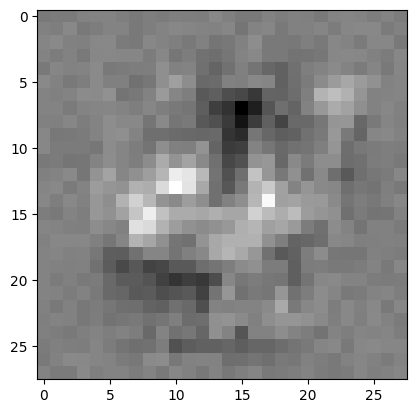

Epoch[82/100], loss: 0.140522, acc: 0.976000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


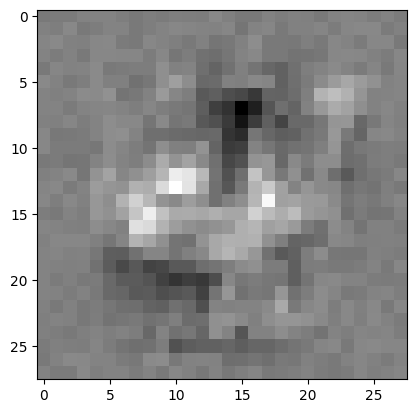

Epoch[83/100], loss: 0.140153, acc: 0.976000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


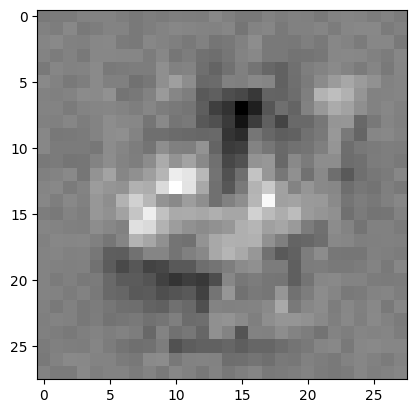

Epoch[84/100], loss: 0.139786, acc: 0.976000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


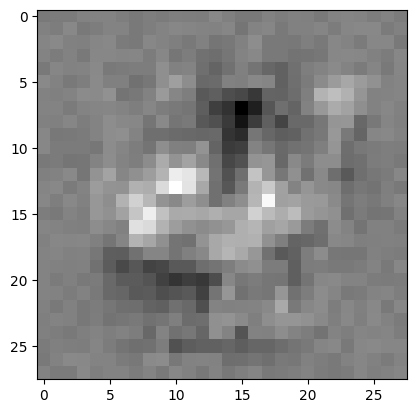

Epoch[85/100], loss: 0.139420, acc: 0.976000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


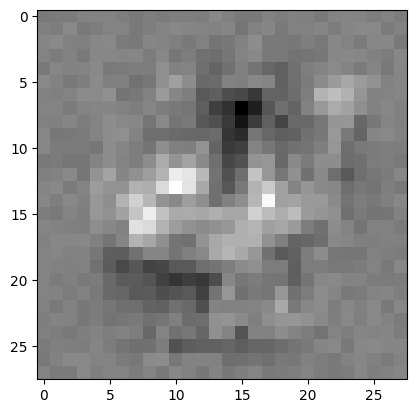

Epoch[86/100], loss: 0.139056, acc: 0.976000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


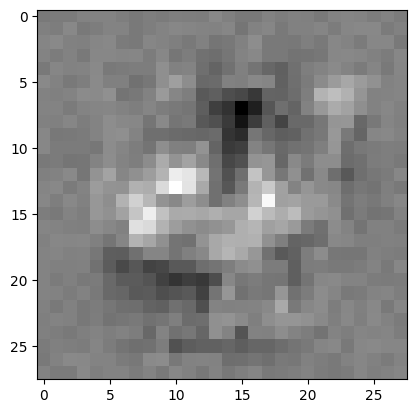

Epoch[87/100], loss: 0.138694, acc: 0.976000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


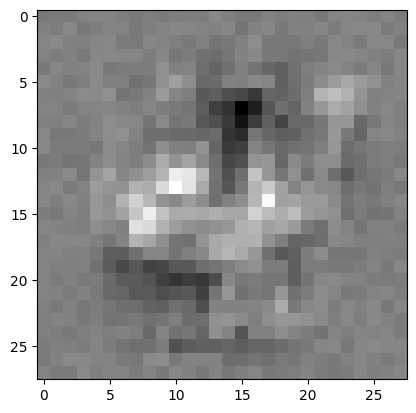

Epoch[88/100], loss: 0.138334, acc: 0.976000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


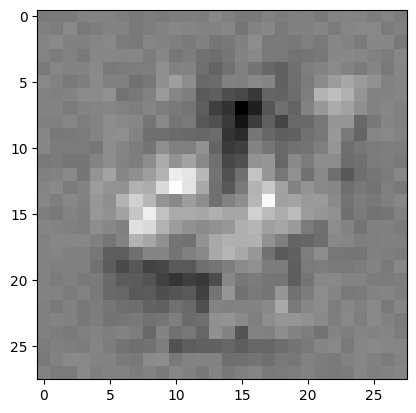

Epoch[89/100], loss: 0.137975, acc: 0.976000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


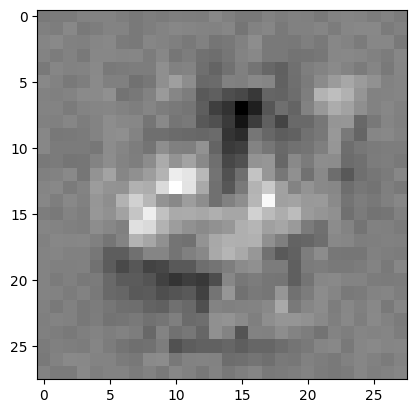

Epoch[90/100], loss: 0.137618, acc: 0.976000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


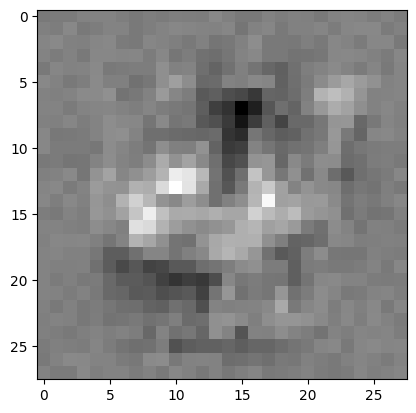

Epoch[91/100], loss: 0.137262, acc: 0.976000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


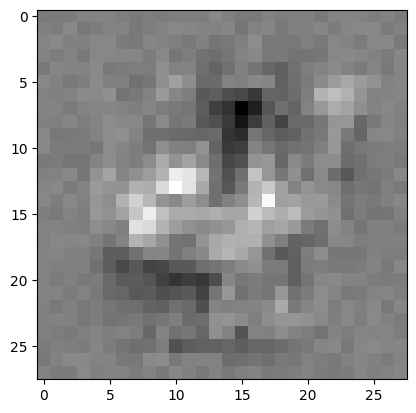

Epoch[92/100], loss: 0.136909, acc: 0.976000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


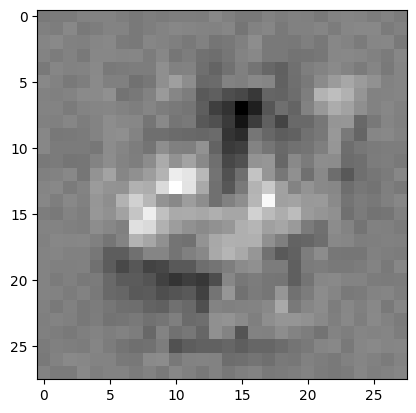

Epoch[93/100], loss: 0.136557, acc: 0.976000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


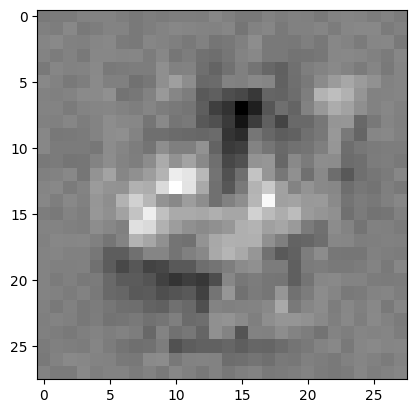

Epoch[94/100], loss: 0.136206, acc: 0.976000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


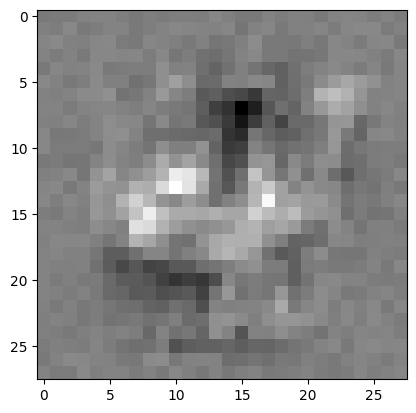

Epoch[95/100], loss: 0.135857, acc: 0.976000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


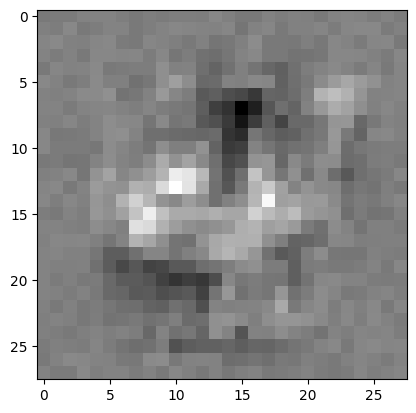

Epoch[96/100], loss: 0.135510, acc: 0.976000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


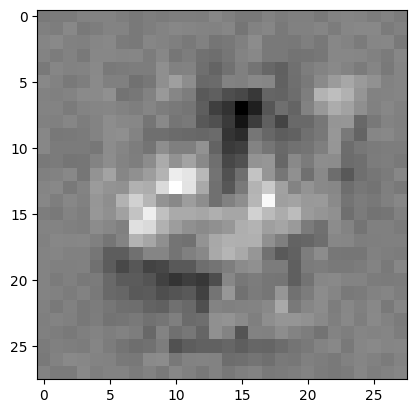

Epoch[97/100], loss: 0.135164, acc: 0.976000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


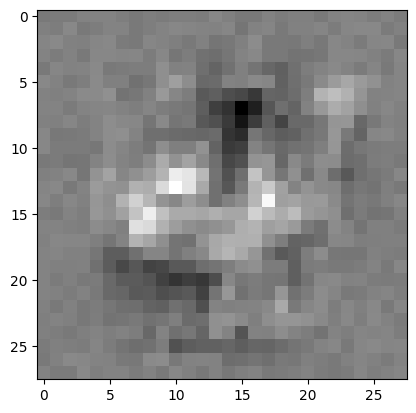

Epoch[98/100], loss: 0.134820, acc: 0.976000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


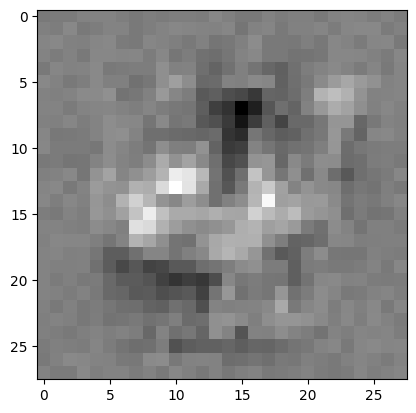

Epoch[99/100], loss: 0.134478, acc: 0.976000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


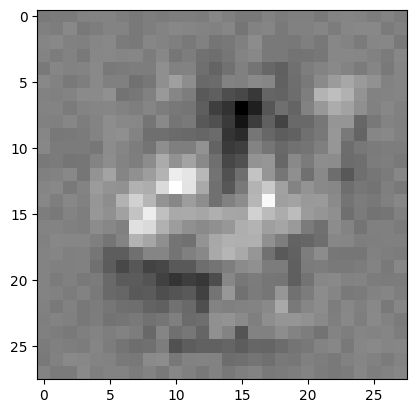

Epoch[100/100], loss: 0.134137, acc: 0.976000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


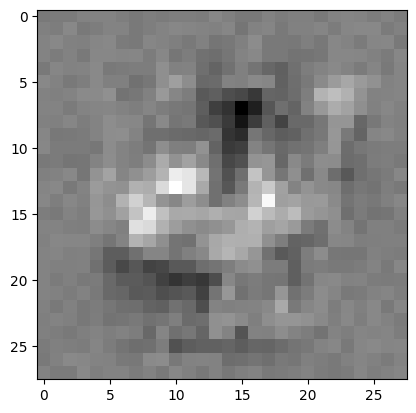

In [46]:
# Exercicio 2

losses = []
import numpy

import numpy
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()

    print('Epoch[{}/{}], loss: {:.6f}, acc: {:.6f}'
              .format(i+1, epochs, loss.data, accuracy))

    weights = model.state_dict()['weight']
    print('weights:', weights.shape)

    bias = model.state_dict()['bias']
    print('bias:   ', bias.shape)

    # Visualizando pesos da classe do digito 4
    plt.imshow(weights[4, :].numpy().reshape((28,28)),cmap = 'gray')
    plt.show()


## Perguntas

1. Qual é o shape da matriz de entrada na rede?

  R - [1000,784]
2. Qual é o shape da saída da rede?

  R - [1000,10]

3. Qual é o número total de parâmetros da rede, incluindo o bias?

  R - Total = 784 x 10 + 10 (Bias) = 7.850 parametros treinaveis.
```
# Isto está formatado como código
```



# Aprendizados
